In [1]:
%cd drive/MyDrive/collab_sandbox/cerf_text_classification/
!ls

/content/drive/MyDrive/collab_sandbox/cerf_text_classification
blend_models
cerf_classification_cross_distilroberta-base
cerf_classification_distilroberta-base
cerf_classification_machine_learning.ipynb
cerf_classification_roberta-base
cerf_parsing.ipynb
CERF_texts_parsing.zip
cert_classification.ipynb
datasets
learnamericanenglishonline_links.csv
learnamericanenglishonline_links.gsheet
manual_dataset_texts.gsheet
models
runs
wandb


In [2]:
!pip install -q transformers==4.6.1 datasets wandb sentencepiece

In [3]:
import pandas as pd
import os
from transformers import TrainingArguments, AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import nn
import torch 
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def seed_all():
  SEED = 1234
 
  # random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
seed_all()

In [ ]:
# base_dir = "./datasets/"
# datasets_list = os.listdir(base_dir)
# texts_dataset = pd.DataFrame(columns=['source_text', 'level', 'link', 'name', 'metadata'])

# for data_path in datasets_list:
#   data_path = base_dir + data_path
#   text_dataset = pd.read_csv(data_path)
#   texts_dataset = pd.concat([texts_dataset, text_dataset], ignore_index=True)

# texts_dataset = texts_dataset[['source_text', 'level']]
# texts_dataset.to_csv("./datasets/level_texts_1968.csv", index=False)

In [ ]:
# texts_dataset = pd.read_csv("./datasets/level_texts_1968.csv", lineterminator='\n')
# texts_dataset['source_text'] = texts_dataset['source_text'].apply(str)
# texts_dataset['source_text_len'] = texts_dataset['source_text'].apply(len)

# def filter_dataset(dataset):
#   l_d = dataset['level']
#   t_d = dataset['source_text_len']
#   dataset = dataset[((l_d == 'A1') |
#                 (l_d == 'A2') |
#                 (l_d == 'B1') |
#                 (l_d == 'B2') |
#                 (l_d == 'C1')) &
#                 (t_d > 10)
#                 ]
#   return dataset

# texts_dataset = filter_dataset(texts_dataset)
# texts_dataset.to_csv("./datasets/level_texts_1959.csv", index=False)
# texts_dataset['level'].value_counts().sort_values().plot(kind = 'barh')

## Create Dataset

In [4]:
texts_dataset = pd.read_csv("./datasets/level_texts_1959.csv", lineterminator='\n')

In [13]:
texts_dataset

,source_text,level,source_text_len
0,I am new to the city. I do not know anyone. Bu...,A1,796
1,This is Meg. Meg lives in South Africa. She ha...,A1,783
2,It is hard to be a farmer. Cold weather can ki...,A1,1053
3,The tomato is from South America. When the tom...,A1,1762
4,A man named Randy liked to hunt trees. He look...,A1,931
...,...,...,...
1954,Two com pletely d iffe re n t photos have been...,C1,660
1955,"""Slaves captured in raids and w ar grew in im ...",C1,620
1956,If Christian Munoz-Donoso is going to make thi...,C1,2743
1957,Having decided to take the experiment out to a...,C1,509


In [7]:
for level in ['A1', 'A2', 'B1', 'B2', 'C1']:
  amount = len(texts_dataset[texts_dataset['level'] == level])
  print(f"{level}={amount}", end=' ')

A1=396 A2=458 B1=530 B2=450 C1=125 

Token indices sequence length is longer than the specified maximum sequence length for this model (990 > 512). Running this sequence through the model will result in indexing errors


,source_text,level,source_text_len
0,I am new to the city. I do not know anyone. Bu...,A1,200
1,This is Meg. Meg lives in South Africa. She ha...,A1,190
2,It is hard to be a farmer. Cold weather can ki...,A1,246
3,The tomato is from South America. When the tom...,A1,413
4,A man named Randy liked to hunt trees. He look...,A1,217
...,...,...,...
1954,Two com pletely d iffe re n t photos have been...,C1,205
1955,"""Slaves captured in raids and w ar grew in im ...",C1,146
1956,If Christian Munoz-Donoso is going to make thi...,C1,614
1957,Having decided to take the experiment out to a...,C1,114


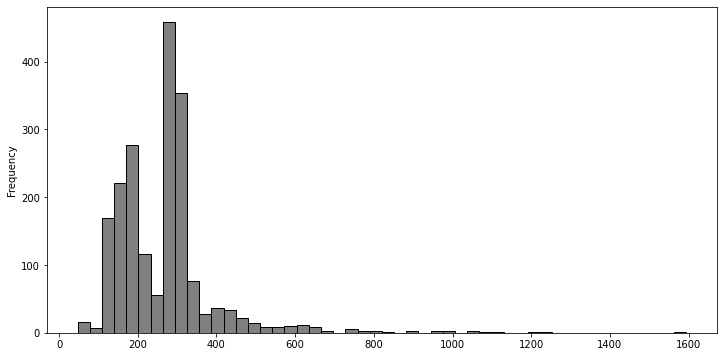

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokens_amount(text):
  return len(tokenizer(text)['input_ids'])
texts_dataset['source_text_len'] = texts_dataset['source_text'].apply(tokens_amount)
texts_dataset['source_text_len'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black')
texts_dataset

In [5]:
pretrained_model_name = "distilroberta-base"
class CERFDataset(Dataset):
  def __init__(self, dataset_csv=None, model=pretrained_model_name ):
    tokenizer = AutoTokenizer.from_pretrained(model)
    self.tokenizer = tokenizer
    self.dataset_csv = dataset_csv.reset_index().to_dict('records')
    self.max_len = 512
    self.dataset = None
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.targets = {
        'A1': 0,
        'A2': 1,
        'B1': 2,
        'B2': 3,
        'C1': 4
    }

  def __len__(self):
    return len(self.dataset_csv)

  def __getitem__(self, idx):
    example = self.dataset_csv[idx]

    source_encoding = self.tokenizer(
      example['source_text'],
      max_length=self.max_len,
      padding='max_length',
      pad_to_max_length=True,
      truncation=True,
    )
    
    target_label = self.targets[example['level']]

    return {'input_ids': torch.tensor(source_encoding['input_ids'], ),#device=self.device),
            'label_ids': torch.tensor([target_label] ),#device=self.device), 
            'attention_mask': torch.tensor(source_encoding['attention_mask'], )}#device=self.device)}

In [ ]:
train_data, val_data = train_test_split(texts_dataset, test_size=0.15, random_state=1234)
train_dataset = CERFDataset(train_data)
val_dataset = CERFDataset(val_data)
len(train_dataset), len(val_dataset)

(1665, 294)

In [ ]:
# %env WANDB_PROJECT=cerf_classification
# import wandb
# wandb.login()

env: WANDB_PROJECT=cerf_classification


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# class ModelClassificationHead(nn.Module):
#     """Head for sentence-level classification tasks."""

#     def __init__(self, config):
#         super().__init__()
#         self.dense = nn.Linear(config.hidden_size, config.hidden_size)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

#     def forward(self, features, **kwargs):
#         x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
#         x = self.dropout(x)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         x = self.out_proj(x)
#         return x

#     def predict_prob(self, features, **kwargs):
#         x = features[:, 0, :]  
#         x = self.dropout(x)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         return x

# class ModelForSequenceClassification(nn.Module):
#   def __init__(self, transformer, device, n_tags, dropout = 0.1):
#         super(ModelForSequenceClassification, self).__init__()
        
#         self.model = RobertaModel(config, add_pooling_layer=False)
#         self.classifier = RobertaClassificationHead(config)

#         self.device = device
#         # amount_params = len([item for item in self.transformer.parameters()])
#         # step = 0
#         # freeze_params = int(amount_params * 0.7)
#         # for param in self.transformer.parameters():
#         #   if step < freeze_params:
#         #     param.requires_grad = False
#         #   step += 1

#     def forward(self, label_ids=None, attention_mask=None, labels=None, ):
#       outputs = self.roberta(
#           input_ids,
#           attention_mask=attention_mask,)
#       sequence_output = outputs[0]
#       logits = self.classifier(sequence_output)
#       if labels is not None:
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#         output = (logits,) + outputs[2:]
#         return ((loss,) + output) if loss is not None else output
#       return outputs
#     def predict_prob(self, input_ids=None, attention_mask=None, ):
#       ...


In [ ]:
batch_size = 16
pretrained_model_name = "distilroberta-base"
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=5)

args = TrainingArguments(
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f_1',
    report_to="wandb",
    eval_steps=100,
    logging_steps=100,
    # metric_for_best_model='eval_loss',
    output_dir=f"./cerf_classification_{pretrained_model_name}/",
    run_name=f"cerf_classification_{pretrained_model_name}",
    evaluation_strategy="steps",
    save_total_limit= 1,
    warmup_steps=0,    
    adam_epsilon=1.0e-08,
    # gradient_accumulation_steps=2,
)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f_1 = f1_score(labels, preds, average='weighted')
  return {
      'f_1': f_1,
  }

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

In [ ]:
trainer.train()
trainer.save_model()
wandb.finish()

wandb: Currently logged in as: dimweb (use `wandb login --relogin` to force relogin)


Step,Training Loss,Validation Loss,F 1
100,1.158200,0.706178,0.625889
200,0.547700,0.537346,0.795277
300,0.336200,0.416091,0.836351
400,0.312200,0.420677,0.845429
500,0.228700,0.388106,0.858526


train/loss,0.2287
train/learning_rate,0.0
train/epoch,5.0
train/global_step,525
_runtime,294
_timestamp,1622196236
_step,10
eval/loss,0.38811
eval/f_1,0.85853
eval/runtime,3.0731
eval/samples_per_second,95.67


train/loss,█▃▂▂▁
train/learning_rate,█▆▅▃▁
train/epoch,▁▁▃▃▄▄▆▆███
train/global_step,▁▁▃▃▄▄▆▆███
_runtime,▁▁▃▃▄▄▆▆▇██
_timestamp,▁▁▃▃▄▄▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
eval/loss,█▄▂▂▁
eval/f_1,▁▆▇██
eval/runtime,█▂▁▇▇
eval/samples_per_second,▁▇█▂▂


In [ ]:
pretrain_model = AutoModelForSequenceClassification.from_pretrained('./cerf_classification_distilroberta-base/', num_labels=5)

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(val_dataset)
dataloader

In [ ]:
# item = val_dataset[0]
# input_ids = item['input_ids'].unsqueeze(0)
# attention_mask = item['attention_mask'].unsqueeze(0)
# with torch.no_grad():
#   print(pretrain_model(input_ids, attention_mask)['logits'].argmax(-1))

tensor([1])


In [ ]:

for item in val_dataset:
  input_ids = item['input_ids'].unsqueeze(0)
  attention_mask = item['attention_mask'].unsqueeze(0)
  with torch.no_grad():
    print(pretrain_model(input_ids, attention_mask)['logits'].argmax(-1))

# KFold validation

In [18]:
from sklearn.model_selection import KFold
import torch

%env WANDB_PROJECT=cerf_classification
import wandb
wandb.login()

class Experiment:
  def __init__(self, 
           dataset = None,
           folds_amount = 5,
           model = None
           ):
    assert not model is None
    self.dataset = dataset
    self.model = model

    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.seed = 1234

    # cross validation
    self.folds_amount = folds_amount
    self.k_fold = KFold(n_splits=self.folds_amount, random_state=self.seed, shuffle=True)

  def experiment(self):
    
    CV_score_array = []
    
    for train_index, test_index in self.k_fold.split(self.dataset):
      train_dataset = self.dataset.iloc[train_index].reset_index(drop=True)
      test_dataset = self.dataset.iloc[test_index].reset_index(drop=True)
      train_dataset = CERFDataset(train_dataset, model=self.model)
      test_dataset = CERFDataset(test_dataset, model=self.model)

      batch_size = 16
      model = AutoModelForSequenceClassification.from_pretrained(self.model, num_labels=5)

      # wandb.init()
      args = TrainingArguments(
          learning_rate=2e-5,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          num_train_epochs=6,
          weight_decay=0.01,
          load_best_model_at_end=True,
          metric_for_best_model='f_1',
          eval_steps=100,
          logging_steps=100,
          # metric_for_best_model='eval_loss',
          output_dir=f"./cerf_classification_cross_{self.model}/",
          run_name=f"cerf_classification_cross_{self.model}",
          report_to="wandb",
          evaluation_strategy="steps",
          save_total_limit= 1,
          warmup_steps=0,    
          adam_epsilon=1.0e-8,
      )

      def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        f_1 = f1_score(labels, preds, average='weighted')
        return {
            'f_1': f_1,
        }

      trainer = Trainer(
          model,
          args,
          train_dataset=train_dataset,
          eval_dataset=test_dataset,
          compute_metrics=compute_metrics,
      )

      trainer.train()
      eval_result = trainer.evaluate(test_dataset)
      wandb.finish()
      # print(eval_result)
      CV_score_array.append(eval_result['eval_f_1'])
    
    print(CV_score_array)
    average_f1 = sum(CV_score_array) / len(CV_score_array)
    print(f'Average f1_score={average_f1}')
      

env: WANDB_PROJECT=cerf_classification


In [19]:
classif_exp = Experiment(model='distilroberta-base', dataset=texts_dataset)

In [20]:
classif_exp.experiment()

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Step,Training Loss,Validation Loss,F 1
100,1.156800,0.669920,0.662220
200,0.632000,0.490045,0.843642
300,0.415200,0.381862,0.870471
400,0.277700,0.350733,0.883064
500,0.214600,0.389684,0.875290


train/loss,0.2146
train/learning_rate,0.0
train/epoch,6.0
train/global_step,588
_runtime,487
_timestamp,1623853387
_step,11
eval/loss,0.35073
eval/f_1,0.88306
eval/runtime,4.6935
eval/samples_per_second,83.52


train/loss,█▄▂▁▁
train/learning_rate,█▆▄▃▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
_runtime,▁▁▂▃▄▄▅▅▇▇██
_timestamp,▁▁▂▃▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
eval/loss,█▄▂▁▂▁
eval/f_1,▁▇████
eval/runtime,█▂▃▃▁▅
eval/samples_per_second,▁▇▆▆█▄


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Step,Training Loss,Validation Loss,F 1
100,1.130200,0.790910,0.629881
200,0.602800,0.574176,0.755357
300,0.398300,0.424331,0.839208
400,0.288500,0.349272,0.873653
500,0.212300,0.468507,0.821217


train/loss,0.2123
train/learning_rate,0.0
train/epoch,6.0
train/global_step,588
_runtime,488
_timestamp,1623853884
_step,11
eval/loss,0.34927
eval/f_1,0.87365
eval/runtime,4.6584
eval/samples_per_second,84.149


train/loss,█▄▂▂▁
train/learning_rate,█▆▄▃▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
_runtime,▁▁▂▂▄▄▅▅▇▇██
_timestamp,▁▁▂▂▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
eval/loss,█▅▂▁▃▁
eval/f_1,▁▅▇█▆█
eval/runtime,█▇▁▃▃▁
eval/samples_per_second,▁▂█▆▆█


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Step,Training Loss,Validation Loss,F 1
100,1.137200,0.740874,0.686472
200,0.619800,0.503475,0.839893
300,0.407500,0.478471,0.833043
400,0.289900,0.469727,0.841800
500,0.224700,0.442626,0.858479


train/loss,0.2247
train/learning_rate,0.0
train/epoch,6.0
train/global_step,588
_runtime,487
_timestamp,1623854379
_step,11
eval/loss,0.44263
eval/f_1,0.85848
eval/runtime,4.7089
eval/samples_per_second,83.247


train/loss,█▄▂▂▁
train/learning_rate,█▆▄▃▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
_runtime,▁▁▂▃▄▄▅▅▇▇██
_timestamp,▁▁▂▃▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
eval/loss,█▂▂▂▁▁
eval/f_1,▁▇▇▇██
eval/runtime,█▂▁▂▂▂
eval/samples_per_second,▁▇█▇▇▇


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Step,Training Loss,Validation Loss,F 1
100,1.150700,0.772249,0.683007
200,0.616600,0.471245,0.828977
300,0.389400,0.411739,0.854016
400,0.288000,0.416616,0.842956
500,0.219500,0.360019,0.869136


train/loss,0.2195
train/learning_rate,0.0
train/epoch,6.0
train/global_step,588
_runtime,488
_timestamp,1623854877
_step,11
eval/loss,0.36002
eval/f_1,0.86914
eval/runtime,4.7511
eval/samples_per_second,82.507


train/loss,█▄▂▂▁
train/learning_rate,█▆▄▃▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
_runtime,▁▁▂▃▄▄▅▅▇▇██
_timestamp,▁▁▂▃▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
eval/loss,█▃▂▂▁▁
eval/f_1,▁▆▇▇██
eval/runtime,█▁▁▁▇▃
eval/samples_per_second,▁███▂▆


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

Step,Training Loss,Validation Loss,F 1
100,1.130100,0.682169,0.729316
200,0.539300,0.492140,0.848145
300,0.414600,0.462021,0.840992
400,0.290000,0.383578,0.877056
500,0.212200,0.405539,0.864966


train/loss,0.2122
train/learning_rate,0.0
train/epoch,6.0
train/global_step,588
_runtime,490
_timestamp,1623855376
_step,11
eval/loss,0.38358
eval/f_1,0.87706
eval/runtime,4.7254
eval/samples_per_second,82.744


train/loss,█▃▃▂▁
train/learning_rate,█▆▄▃▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
_runtime,▁▁▂▂▄▄▅▅▇▇██
_timestamp,▁▁▂▂▄▄▅▅▇▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█
eval/loss,█▄▃▁▂▁
eval/f_1,▁▇▆█▇█
eval/runtime,█▁▃▂▁▂
eval/samples_per_second,▁█▆▇█▇


[0.8830643516564011, 0.87365277959568, 0.8584789690308737, 0.8691356901750587, 0.8770560097328439]
Average f1_score=0.8722775600381716


In [21]:
1

1